In [1]:
import timeflow as tflow
import timesynth as ts
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
train_data = np.loadtxt('data/ChlorineConcentration/ChlorineConcentration_TRAIN', delimiter=',')

In [3]:
X_class_train = train_data[:, 1:]
Y_class_train_ = list(train_data[:, 0])

In [4]:
def convert_to_one_hot(value, num_classes=3):
    one_hot = [0]*num_classes
    one_hot[int(value-1)]=1
    return one_hot

In [5]:
Y_class_train = np.array(map(convert_to_one_hot, Y_class_train_))

In [6]:
input_size = 1
hidden_size = 10
output_size = 3
batch_size = 467

In [7]:
with tf.variable_scope('Input'):
    inputs = tflow.placeholders.prediction.input_batch_placeholder(input_size, batch_size)
with tf.variable_scope('Input_LSTM_Layer'):
    input_lstm_layer = tflow.layers.InputLSTMLayer(inputs, input_size, batch_input=True)
with tf.variable_scope('LSTM_Layer'):
    lstm_layer = tflow.layers.LSTMLayer(input_size, hidden_size, input_lstm_layer)
with tf.variable_scope('Regression_Layer'):
    reg_layer = tflow.layers.RegressionLayer(hidden_size, output_size, lstm_layer)
with tf.variable_scope('Output_LSTM_Layer'):
    output_layer = tflow.layers.OutputLSTMLayer(output_size, reg_layer, batch_output=True)

In [8]:
outputs = output_layer.get_outputs()
last_output = tf.reverse(outputs,[False, True, False])[:, 0, :]
output=tf.nn.softmax(last_output)

In [9]:
y = tf.placeholder(tf.float32, shape=[batch_size, output_size],name='outputs')

In [10]:
#Defining cross entropy
with tf.variable_scope('cross_entropy'):
    cross_entropy = -tf.reduce_sum(y * tf.log(output))
with tf.variable_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(output,1))
    accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100

In [11]:
tf.scalar_summary("Cross Entropy", cross_entropy)
tf.scalar_summary("Accuracy", accuracy)
summary_op = tf.merge_all_summaries()

In [12]:
# Training with Adadelta Optimizer
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

In [13]:
# Starting tensorflow session
sess=tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [14]:
#Setting up log directory for tensorboard
logs_path = 'tmp/cls/1'
writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())

In [15]:
data_len, time_series_len = X_class_train.shape
X_class_train_reshaped = np.reshape(X_class_train, (data_len, time_series_len, 1))

In [ ]:
for i in range(10):
    _, summary = sess.run([train_step, summary_op],
                         feed_dict={inputs:X_class_train_reshaped,
                                    y:Y_class_train})
    writer.add_summary(summary, i)

#### SNCC dataset

In [16]:
import re
import pandas as pd
import matplotlib.gridspec as gridspec
def read_snpcc_lc(fname, data_path):
    start_line=0
    with open(data_path+fname) as f:
        for line in f:
            s=re.findall('SNTYPE:\s*([-+]?\d+)', line)
            if s:
                sn_class_snpcc = int(s[0])
            s=re.findall('HOST_GALAXY_PHOTO-Z:\s*(\d+\.\d+)', line)
            if s:
                photo_z = float(s[0])
            s=re.findall('SN Type = (\w+) ,', line)
            if s:
                sn_class = s[0]
            s=re.search('VARLIST:', line)
            if s:
                break
            start_line += 1
    try:
        df = pd.read_table(data_path+fname, skiprows=start_line, delim_whitespace=True)
    except:
        print(fname)
    bands=['g', 'r', 'i', 'z']
    lc = list()
    for i in range(0, len(bands)):
        #tmp = df.query("FLT=='"+str(bands[i])+"' and SNR>0.0").ix[:, ["MJD","FLUXCAL", "FLUXCALERR"]]
        tmp = df.query("FLT=='"+str(bands[i])+"'").ix[:, ["MJD","FLUXCAL", "FLUXCALERR"]]
        tmp = tmp.astype(float).as_matrix()
        lc.append(tmp)
    return lc, photo_z, sn_class, sn_class_snpcc

def plot_snpcc_lc(lc):
    bands=['g', 'r', 'i', 'z']
    colors=['g', 'r', 'm', 'k']
    fig = plt.figure(figsize=(12, 6), dpi=150)
    gs = gridspec.GridSpec(2, 2)
    for i in range(0, len(bands)):
        #ax = fig.add_subplot(4, 1, i+1)
        ax = plt.subplot(gs[i])
        ax.set_title(bands[i])
        ax.errorbar(lc[i][:, 0], lc[i][:, 1], yerr=lc[i][:, 2], color=colors[i], linewidth=1, fmt='.', label=bands[i])
        ax.set_xlabel('MJD')
        ax.set_ylabel('FLUX')
        if i > 0: 
            if xmax < ax.get_xlim()[1]:
                xmax = ax.get_xlim()[1]
            if xmin > ax.get_xlim()[0]:
                xmin = ax.get_xlim()[0]
        else:
            xmin, xmax = ax.get_xlim()
    for i in range(0, len(bands)):
        ax = plt.subplot(gs[i])
        ax.set_xlim([xmin, xmax])
        plt.grid()
    gs.tight_layout(fig)

In [17]:
lc, photo_z, sn_class, sn_class_snpcc = read_snpcc_lc('DES_SN000017.DAT', '../../Desktop/SNPCC/data/')

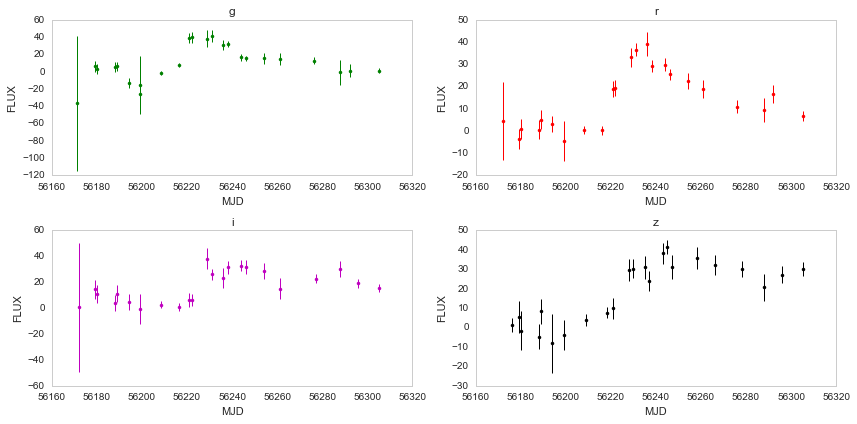

In [18]:
plot_snpcc_lc(lc)